## Классификация изображений животных

В качестве предобученной модели взят ResNet50. Обучение происходит на данных, которые делятся на 5 классов, среди которых наблюдается дисбаланс. Запущено 10 эпох. Accuracy -- 0.7796.

### Установка и загрузка библиотек

Установка sampler для борьбы с дисбалансом.

In [1]:
!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip

     |████████████████████████████████| 297 kB 1.4 MB/s 
  Created wheel for torchsampler: filename=torchsampler-0.1.1-py3-none-any.whl size=3839 sha256=a956ba17cf47a7720eb467423825914fe3fab97fd9803e69ce8dee9bfbdf88a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-jp1i41y_/wheels/52/7b/7d/ce0e0ddbb7864877a0e31a96f883a928791ebfa6eaf7b52f87
Successfully built torchsampler


Клонирование репозитория

In [2]:
!git clone https://github.com/Elena-Semerova/WildHack.git

Cloning into 'WildHack'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 99 (delta 31), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (99/99), done.


Импортирование нужных библиотек (включая функции из репозитория)

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import models, transforms
from torch.optim import lr_scheduler

import warnings
warnings.simplefilter("ignore", UserWarning)

from WildHack.model.image_dataloaders import make_train_val_dataloaders, make_test_dataloader
from WildHack.model.classifier import model_to_classifier
from WildHack.model.train import train
from WildHack.model.utils import saving, seed
from WildHack.model.visualization import imshow, visualize_predictions

Подключение Google Drive (где хранятся данные)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Обучение модели

#### Переменные, трансформации и seed

Объявление глобальных переменных (в репозитории -- config.py)

In [5]:
TRAIN_DATAPATH = 'drive/MyDrive/dataset_animals_5/train'
VAL_DATAPATH = 'drive/MyDrive/dataset_animals_5/val'
TEST_DATAPATH = 'drive/MyDrive/dataset_animals_5/test'

BATCH_SIZE = 4
NUM_WORKERS = 2
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9
STEP_SIZE = 7
GAMMA = 0.1

CLASS_NAMES = ['another', 'deer', 'fox','tiger', 'wolf']
NUM_CLASSES = len(CLASS_NAMES)

SEED = 7

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

MODEL_FILE_NAME = 'resnet18_' + str(NUM_EPOCHS) + '_cat_' + str(NUM_CLASSES)

Трансформации для разного вида данных (можно менять, в репозитории находятся в main.py) + установка seed

In [6]:
data_transforms = {
  'train': transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'val': transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'test': transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
}

seed(SEED)

#### Создание dataloaders и просмотр изображений, подаваемых в обучение

Dataloaders (при помощи функции из репозитория -- image_dataloaders.py)

In [7]:
train_dataloader, val_dataloader, train_size, val_size = make_train_val_dataloaders(TRAIN_DATAPATH,
                                                                                    VAL_DATAPATH,
                                                                                    data_transforms['train'],
                                                                                    data_transforms['val'],
                                                                                    BATCH_SIZE,
                                                                                    NUM_WORKERS)
test_dataloader = make_test_dataloader(TEST_DATAPATH,
                                       data_transforms['test'],
                                       NUM_WORKERS)

Визуализация изображений при помощи функции из visualization.py

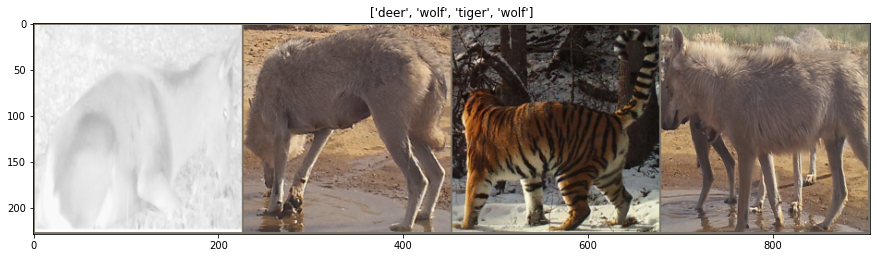

In [8]:
inputs, classes = next(iter(train_dataloader))
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(15, 12))

imshow(out, title=[CLASS_NAMES[x] for x in classes])

#### Создание и обучение модели

Загружаем предобученную модель ResNet18, переделываем ее под классификатор и задаем критерий, оптимизатор и шедулер.

In [9]:
model = models.resnet50(pretrained=True)
model, params = model_to_classifier(model, DEVICE, NUM_CLASSES)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Обучаем модель

In [10]:
model = train(model, train_dataloader, val_dataloader, train_size, val_size, criterion, optimizer, scheduler, DEVICE, NUM_EPOCHS)

Epoch 1/10
--------------------------------------------------
	 train loss: 0.3506 	 train acc: 0.5751
	 val loss: 0.3112 	 val acc: 0.7355
Time for epoch 2m 17s

Epoch 2/10
--------------------------------------------------
	 train loss: 0.3066 	 train acc: 0.7524
	 val loss: 0.2980 	 val acc: 0.7355
Time for epoch 1m 15s

Epoch 3/10
--------------------------------------------------
	 train loss: 0.2970 	 train acc: 0.7691
	 val loss: 0.2884 	 val acc: 0.7741
Time for epoch 1m 7s

Epoch 4/10
--------------------------------------------------
	 train loss: 0.2901 	 train acc: 0.7907
	 val loss: 0.2870 	 val acc: 0.7548
Time for epoch 1m 3s

Epoch 5/10
--------------------------------------------------
	 train loss: 0.2878 	 train acc: 0.8025
	 val loss: 0.2855 	 val acc: 0.7603
Time for epoch 1m 2s

Epoch 6/10
--------------------------------------------------
	 train loss: 0.2850 	 train acc: 0.7962
	 val loss: 0.2843 	 val acc: 0.7741
Time for epoch 1m 1s

Epoch 7/10
---------------

Сохраняем модель

In [11]:
saving(model, MODEL_FILE_NAME)

### Предсказания на тестовом наборе изображений

Визуализируем предсказания для приготовленных тестовых картинок.

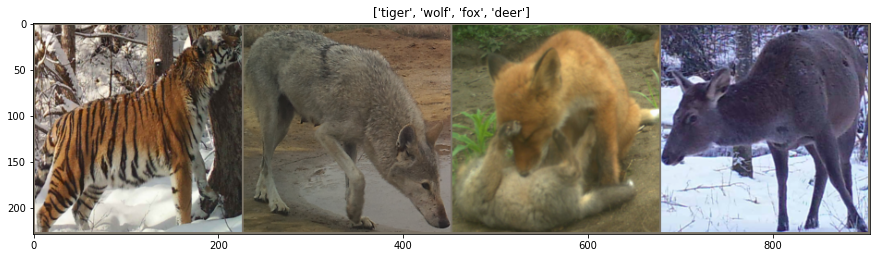

In [12]:
plt.figure(figsize=(15, 12))
visualize_predictions(model, test_dataloader, CLASS_NAMES, DEVICE)